In [104]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod
from art.attacks import BasicIterativeMethod
from art.defences import AdversarialTrainer

import pickle
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.model_selection import StratifiedKFold

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [105]:
A = open('/home/rkarim/OncoNetExplainer_GE/CancerTypePrediction/TCGA_new_pre_second.pckl', 'rb')
[dropped_genes_final, dropped_gene_name, dropped_Ens_id, samp_id_new, diag_name_new,
 project_ids_new] = pickle.load(A)
A.close()

f = open('/home/rkarim/OncoNetExplainer_GE/CancerTypePrediction/TCGA_new_pre_first.pckl', 'rb')
[_, _, _, _, remain_cancer_ids_ind, remain_normal_ids_ind] = pickle.load(f)
f.close()

batch_size = 128
epochs = 2
seed = 7
np.random.seed(seed)

In [106]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(project_ids_new)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
onehot_encoded_cancer_samples = onehot_encoded[remain_cancer_ids_ind]

In [107]:
X_cancer_samples_DF = pd.read_csv('/home/rkarim/OncoNetExplainer_GE/CancerTypePrediction/cancer_sample.csv', sep='\t', index_col=None)

In [108]:
X_cancer_samples_DF_2 = X_cancer_samples_DF.iloc[:, 0:63] # 64 features

X_cancer_samples_mat = np.concatenate((X_cancer_samples_DF_2,np.zeros((len(X_cancer_samples_DF_2),1))),axis=1)

In [109]:
## add nine zeros to the end of each sample
X_cancer_samples_mat = np.reshape(X_cancer_samples_mat, (-1, 8, 8))

x_train, x_test, y_train, y_test = train_test_split(X_cancer_samples_mat, onehot_encoded_cancer_samples,
                                                    stratify= onehot_encoded_cancer_samples,
                                                    test_size=0.20, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                    stratify= y_train,
                                                    test_size=0.1, random_state=42)

num_classes = len(y_train[0])

In [110]:
img_rows_train, img_cols_train = len(x_train[0][0]), len(x_train[0])
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
input_img = Input(input_shape)

img_rows_test, img_cols_test = len(x_test[0][0]), len(x_test[0])
x_test = x_test.reshape(x_test.shape[0], img_rows_test, img_cols_test, 1)
x_test = x_test.astype('float32')

img_rows_val, img_cols_val = len(x_val[0][0]), len(x_val[0])
x_val = x_val.reshape(x_val.shape[0], img_rows_val, img_cols_val, 1)
x_val = x_val.astype('float32')

In [111]:
def createKerasModel():  
    tower_1 = Conv2D(32, (1, 8), activation='relu')(input_img)
    tower_1 = MaxPooling2D(1, 2)(tower_1)
    tower_1 = Flatten()(tower_1)

    tower_2 = Conv2D(32, (8, 1), activation='relu')(input_img)
    tower_2 = MaxPooling2D(1, 2)(tower_2)
    tower_2 = Flatten()(tower_2)

    output = keras.layers.concatenate([tower_1, tower_2], axis=1)
    out1 = Dense(128, activation='relu')(output)
    last_layer = Dense(num_classes, activation='softmax')(out1)
    model = Model(input=[input_img], output=last_layer)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

In [112]:
model = createKerasModel()
model.summary()

# Create classifier wrapper
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128, verbose=1, validation_data=(x_val, y_val))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 8, 1, 32)     288         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 1, 8, 32)     288         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 4, 1, 32)     0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [113]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=100, verbose=1, validation_data=(x_val, y_val))

Train on 7444 samples, validate on 828 samples
Epoch 1/100
7444/7444 [==============================] - 0s 19us/step - loss: 0.3566 - categorical_accuracy: 0.8881 - val_loss: 0.4179 - val_categorical_accuracy: 0.8696
Epoch 2/100
7444/7444 [==============================] - 0s 19us/step - loss: 0.3489 - categorical_accuracy: 0.8876 - val_loss: 0.3962 - val_categorical_accuracy: 0.8792
Epoch 3/100
7444/7444 [==============================] - 0s 20us/step - loss: 0.3339 - categorical_accuracy: 0.8960 - val_loss: 0.4026 - val_categorical_accuracy: 0.8768
Epoch 4/100
7444/7444 [==============================] - 0s 19us/step - loss: 0.3310 - categorical_accuracy: 0.8976 - val_loss: 0.4054 - val_categorical_accuracy: 0.8756
Epoch 5/100
7444/7444 [==============================] - 0s 19us/step - loss: 0.3177 - categorical_accuracy: 0.9017 - val_loss: 0.4274 - val_categorical_accuracy: 0.8671
Epoch 6/100
7444/7444 [==============================] - 0s 20us/step - loss: 0.3178 - categorical_accu

<a id="classifier"></a>
## 2. Train and evaluate a baseline classifier

Load the classifier model:

Evaluate the classifier performance on the first 100 original test samples:

In [114]:
x_test_pred = np.argmax(classifier.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Original test data (first 100 images):
Correctly classified: 88
Incorrectly classified: 12


Generate some adversarial samples:

In [115]:
attacker = FastGradientMethod(classifier, eps=0.5)
x_test_adv = attacker.generate(x_test[:100])

And evaluate performance on those:

In [116]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 73
Incorrectly classified: 27


<a id="adv_training"></a>
## 3. Adversarially train a robust classifier

In [117]:
def createRobustKerasModel():  
    tower_1 = Conv2D(64, (1, 8), activation='relu')(input_img)
    tower_1 = MaxPooling2D(1, 2)(tower_1)
    tower_1 = Flatten()(tower_1)

    tower_2 = Conv2D(32, (8, 1), activation='relu')(input_img)
    tower_2 = MaxPooling2D(1, 2)(tower_2)
    tower_2 = Flatten()(tower_2)
    
    tower_3 = Conv2D(16, (8, 1), activation='relu')(input_img)
    tower_3 = MaxPooling2D(1, 2)(tower_3)
    tower_3 = Flatten()(tower_3)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)
    out1 = Dense(256, activation='relu')(output)
    last_layer = Dense(num_classes, activation='softmax')(out1)
    model = Model(input=[input_img], output=last_layer)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

Note: the robust classifier has the same architecture as above, except the first dense layer has **1024** instead of **128** units. (This was recommend by Madry et al. (2017), *Towards Deep Learning Models Resistant to Adversarial Attacks*)

In [118]:
robustModel = createRobustKerasModel()

# Create classifier wrapper
robust_classifier = KerasClassifier(model=robustModel, clip_values=(min_, max_))
#robust_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128, verbose=1, validation_data=(x_val, y_val))

Also as recommended by Madry et al., we use BIM/PGD attacks during adversarial training:

In [120]:
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=5)

Perform adversarial training:

In [121]:
# We had performed this before, starting with a randomly intialized model.
# Adversarial training takes about 80 minutes on an NVIDIA V100.
# The resulting model is the one loaded from mnist_cnn_robust.h5 above.

# Here is the command we had used for the Adversarial Training

trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
trainer.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Epoch 1/1
1/1 [==============================] - 1s 620ms/step - loss: 3.8442 - categorical_accuracy: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s 15ms/step - loss: 3.5669 - categorical_accuracy: 0.0078
Epoch 1/1
1/1 [==============================] - 0s 14ms/step - loss: 3.2755 - categorical_accuracy: 0.0547
Epoch 1/1
1/1 [==============================] - 0s 15ms/step - loss: 3.1765 - categorical_accuracy: 0.0938
Epoch 1/1
1/1 [==============================] - 0s 14ms/step - loss: 3.1642 - categorical_accuracy: 0.1094
Epoch 1/1
1/1 [==============================] - 0s 15ms/step - loss: 3.0098 - categorical_accuracy: 0.1484
Epoch 1/1
1/1 [==============================] - 0s 14ms/step - loss: 3.2367 - categorical_accuracy: 0.0078
Epoch 1/1
1/1 [==============================] - 0s 14ms/step - loss: 2.9956 - categorical_accuracy: 0.2031
Epoch 1/1
1/1 [==============================] - 0s 14ms/step - loss: 3.1189 - categorical_accuracy: 0.1875
Epoch 1/1
1/1 [========

<a id="evaluation"></a>
## 4. Evaluate the robust classifier

Evaluate the robust classifier's performance on the original test data:

In [126]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test, axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_robust_pred))

Original test data (first 100 images):
Correctly classified: 1809
Incorrectly classified: 259


Evaluate the robust classifier's performance on the adversarial test data (**white-box** setting):

In [123]:
attacker_robust = FastGradientMethod(robust_classifier, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test)

In [124]:
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test, axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_adv_robust_pred))

Adversarial test data (first 100 images):
Correctly classified: 1710
Incorrectly classified: 358


Compare the performance of the original and the robust classifier over a range of `eps` values:

In [54]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test)
    x_test_adv_robust = attacker_robust.generate(x_test)
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test, axis=1))]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test, axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

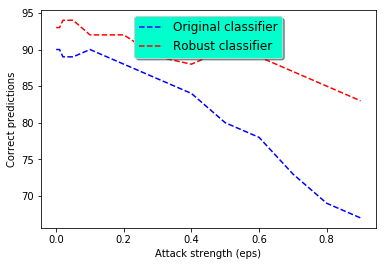

In [125]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()

In [69]:
from functools import reduce
import numpy.linalg as la
from scipy.optimize import fmin as scipy_optimizer
from scipy.stats import weibull_min

from art.attacks import FastGradientMethod
from art.attacks import HopSkipJump
from art.utils import random_sphere
from art.config import ART_NUMPY_DTYPE

def clever_t(classifier, x, target_class, nb_batches, batch_size, radius, norm, c_init=1, pool_factor=10):
    """
    Compute CLEVER score for a targeted attack.
    | Paper link: https://arxiv.org/abs/1801.10578
    :param classifier: A trained model
    :type classifier: :class:`.Classifier`
    :param x: One input sample
    :type x: `np.ndarray`
    :param target_class: Targeted class
    :type target_class: `int`
    :param nb_batches: Number of repetitions of the estimate
    :type nb_batches: `int`
    :param batch_size: Number of random examples to sample per batch
    :type batch_size: `int`
    :param radius: Radius of the maximum perturbation
    :type radius: `float`
    :param norm: Current support: 1, 2, np.inf
    :type norm: `int`
    :param c_init: Initialization of Weibull distribution
    :type c_init: `float`
    :param pool_factor: The factor to create a pool of random samples with size pool_factor x n_s
    :type pool_factor: `int`
    :return: CLEVER score
    :rtype: `float`
    """
    # Check if the targeted class is different from the predicted class
    y_pred = classifier.predict(np.array([x]))
    pred_class = np.argmax(y_pred, axis=1)[0]
    if target_class == pred_class:
        raise ValueError("The targeted class is the predicted class.")

    # Check if pool_factor is smaller than 1
    if pool_factor < 1:
        raise ValueError("The `pool_factor` must be larger than 1.")

    # Some auxiliary vars
    grad_norm_set = []
    dim = reduce(lambda x_, y: x_ * y, x.shape, 1)
    shape = [pool_factor * batch_size]
    shape.extend(x.shape)

    # Generate a pool of samples
    rand_pool = np.reshape(random_sphere(nb_points=pool_factor * batch_size, nb_dims=dim, radius=radius, norm=norm),
                           shape)
    rand_pool += np.repeat(np.array([x]), pool_factor * batch_size, 0)
    rand_pool = rand_pool.astype(ART_NUMPY_DTYPE)
    if hasattr(classifier, 'clip_values') and classifier.clip_values is not None:
        np.clip(rand_pool, classifier.clip_values[0], classifier.clip_values[1], out=rand_pool)

    # Change norm since q = p / (p-1)
    if norm == 1:
        norm = np.inf
    elif norm == np.inf:
        norm = 1
    elif norm != 2:
        raise ValueError("Norm {} not supported".format(norm))

    # Loop over the batches
    for _ in range(nb_batches):
        # Random generation of data points
        sample_xs = rand_pool[np.random.choice(pool_factor * batch_size, batch_size)]

        # Compute gradients
        grads = classifier.class_gradient(sample_xs)
        if np.isnan(grads).any():
            raise Exception("The classifier results NaN gradients.")

        grad = grads[:, pred_class] - grads[:, target_class]
        grad = np.reshape(grad, (batch_size, -1))
        grad_norm = np.max(np.linalg.norm(grad, ord=norm, axis=1))
        grad_norm_set.append(grad_norm)

    # Maximum likelihood estimation for max gradient norms
    [_, loc, _] = weibull_min.fit(-np.array(grad_norm_set), c_init, optimizer=scipy_optimizer)

    # Compute function value
    values = classifier.predict(np.array([x]))
    value = values[:, pred_class] - values[:, target_class]

    # Compute scores
    score = np.min([-value[0] / loc, radius])

    return score

In [70]:
def clever(classifier, x, nb_batches, batch_size, radius, norm, target=None, target_sort=False, c_init=1, pool_factor=10):
    """
    Compute CLEVER score for an untargeted attack.
    | Paper link: https://arxiv.org/abs/1801.10578
    :param classifier: A trained model.
    :type classifier: :class:`.Classifier`
    :param x: One input sample
    :type x: `np.ndarray`
    :param nb_batches: Number of repetitions of the estimate
    :type nb_batches: `int`
    :param batch_size: Number of random examples to sample per batch
    :type batch_size: `int`
    :param radius: Radius of the maximum perturbation
    :type radius: `float`
    :param norm: Current support: 1, 2, np.inf
    :type norm: `int`
    :param target: Class or classes to target. If `None`, targets all classes
    :type target: `int` or iterable of `int`
    :param target_sort: Should the target classes be sorted in prediction order. When `True` and `target` is `None`,
           sort results.
    :type target_sort: `bool`
    :param c_init: initialization of Weibull distribution
    :type c_init: `float`
    :param pool_factor: The factor to create a pool of random samples with size pool_factor x n_s
    :type pool_factor: `int`
    :return: CLEVER score
    :rtype: array of `float`. None if target classes is predicted
    """
    # Find the predicted class first
    y_pred = classifier.predict(np.array([x]))
    pred_class = np.argmax(y_pred, axis=1)[0]
    if target is None:
        # Get a list of untargeted classes
        if target_sort:
            target_classes = np.argsort(y_pred)[0][:-1]
        else:
            target_classes = [i for i in range(classifier.nb_classes()) if i != pred_class]
    elif isinstance(target, (int, np.integer)):
        target_classes = [target]
    else:
        # Assume it's iterable
        target_classes = target
    score_list = []
    for j in target_classes:
        if j == pred_class:
            score_list.append(None)
            continue
        score = clever_t(classifier, x, j, nb_batches, batch_size, radius, norm, c_init, pool_factor)
        score_list.append(score)
        
    return np.array(score_list)

In [96]:
clever_list = clever(robust_classifier, x_test[2], 3, 128, 0.01, 1, target=None, target_sort=False)

In [97]:
clever_list

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])